In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import mannwhitneyu

import statsmodels.api as sm

In [2]:
def load_data(results_dir: str) -> dict:

     # Dictionary to store continents practiced by each participant
     data_dict = {}

     # Iterate over the files in the directory
     for participant_id in os.listdir(results_dir): # participant id is the filename

          # Read the CSV file into a DataFrame
          filepath = os.path.join(results_dir, participant_id)
          df = pd.read_csv(filepath)
          df.insert(1, 'participant_id', participant_id)
          
          # Store the DataFrame in the data_dict dictionary with the participant_id as the key
          data_dict[participant_id] = {'df': df}

     for participant_id, participant_df in data_dict.items():

          # Create a dictionary for the summary statistics
          summary_dict = {
               'avg_rt': participant_df['df']["rt"].mean(),
               'avg_alpha': participant_df['df']["alpha"].mean(),
               'trials': participant_df['df']["trial"].iloc[-1],
               'proportion_correct': participant_df['df']['correct'].value_counts(normalize=True),
               'proportion_correct_per_condition': participant_df['df'].groupby('condition')['correct'].mean(),
               'avg_rt_per_condition': participant_df['df'].groupby('condition')['rt'].mean(),
               'avg_alpha_per_condition': participant_df['df'].groupby('condition')['alpha'].mean(),
               'proportion_correct_per_continent': participant_df['df'].groupby('continent')['correct'].mean(),
               'avg_alpha_per_continent': participant_df['df'].groupby('continent')['alpha'].mean()

               # consider including st.deviation, variance, range
          }

          # Add the summary dictionary to the original dictionary
          data_dict[participant_id]['stats'] = summary_dict

     return data_dict

Populate a dictionary <code><a>data_dict</a></code> with all participant data.

In [3]:
# Results dir
results_dir = './results'

data_dict = load_data(results_dir)

<u>Structure of Stored Data</u>

- <code><a>data_dict[participant_id]</a></code> contains a df with data of participant <code><a>participant_id</a></code> (which is a variable storing a string).
- <code><a>data_dict[participant_id]['df']</a></code> contains the dataframe with all the data of the participant_id.
- <code><a>data_dict[participant_id]['stats']</a></code> contains all the statistics of the participant. 
- To check out what exact statistics are available use <code><a>data_dict[participant_id]['stats'].keys()</a></code>.

In [4]:
def plot_rt_participants(data_dict: dict) -> None:    
    # Concatenate all dfs
    all_data = pd.concat([participant_data['df'] for participant_data in data_dict.values()])

    # Group by the trial number and calculate the mean of 'rt'
    avg_rt_per_trial = all_data.groupby(all_data.index)['rt'].mean()

    # Now avg_rt_per_trial is a Series where the index is the trial number and the value is the average 'rt' for that trial
    plt.figure(figsize=(10, 6))
    avg_rt_per_trial.plot(marker='.', color='#74C365', markerfacecolor='#D35151')
    plt.xlabel('Trial number')
    plt.ylabel('Average RT value')
    plt.title('Average trial RT value across participants')
    plt.show()

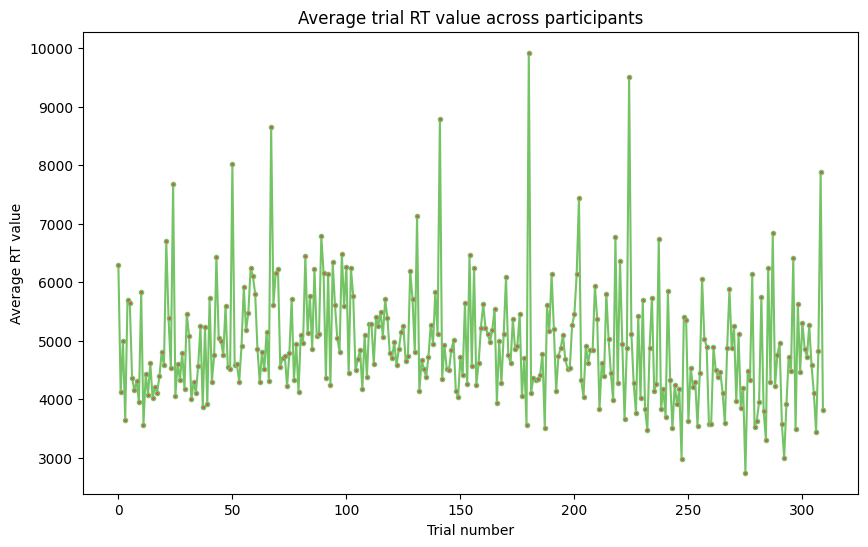

In [5]:
plot_rt_participants(data_dict)

In [6]:
def plot_alpha_participants_per_condition(data_dict: dict) -> None:     
    # Create a DataFrame with the average 'alpha' for each condition for each participant
    data = []
    for participant_id, participant_data in data_dict.items():
        for condition, alpha in participant_data['stats']['avg_alpha_per_condition'].items(): # importantly, participant_data['stats']['avg_alpha_per_condition'] is a dict as ['avg_alpha_per_condition'] is the key and the value is the list containing the avg_alpha of each condition
            data.append({
                'participant_id': participant_id,
                'condition': condition,
                'avg_alpha': alpha
            })
    df = pd.DataFrame(data)

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='condition', y='avg_alpha', data=df, color='#74C365')
    sns.swarmplot(x='condition', y='avg_alpha', data=df, color='#D35151') # a swarmplot plots the participant values themselves (here with red color)

    plt.title('Average Alpha (across participants) per Condition')
    plt.xlabel('Condition')
    plt.ylabel('Average Alpha')
    plt.xticks([0, 1, 2, 3], ['No Context', 'Fact', 'Fact & Image', 'Quiz'])

    plt.show()

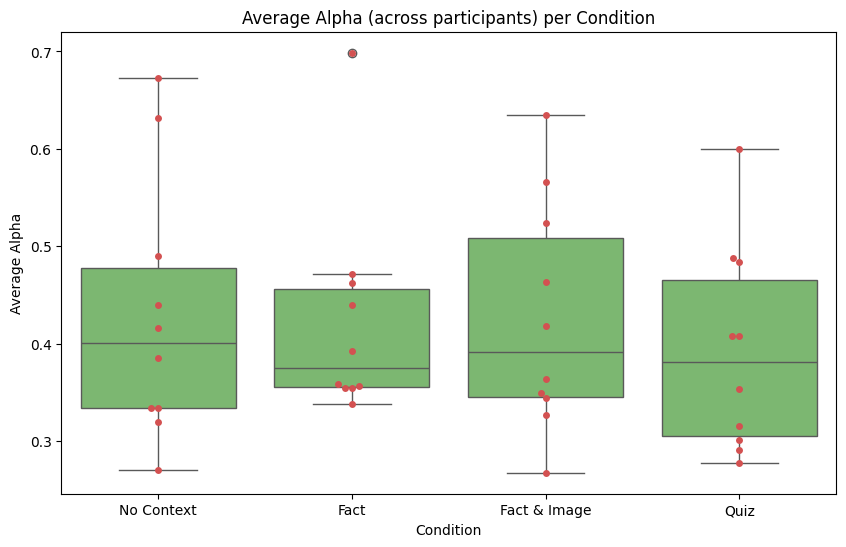

In [7]:
plot_alpha_participants_per_condition(data_dict)

In [8]:
# NEW

In [9]:
# This function creates a lists of four lists (one per condition) with each containing the last alpha value for each item. 
# In this way we want to observe how the alpha values have changed after the learning has happened.

def obtain_last_alpha_per_condition(data_dict: dict) -> list:  
    
    list_alpha_condition1 = []
    list_alpha_condition2 = []
    list_alpha_condition3 = []
    list_alpha_condition4 = []

    for participant_id in data_dict.keys():
        # Access the df of each participant
        df = data_dict[participant_id]['df']

        # Create groups according to each unique 'fact_id'
        descending_df_groupedby_fact = df.groupby('fact_id')

        for fact_id, grouped_facts in descending_df_groupedby_fact:
            facts_groupedby_condition = grouped_facts.groupby('condition')

            # Iterate over each condition in facts_groupedby_condition
            for condition, grouped_condition in facts_groupedby_condition:

                # grouped_condition.to_csv('check.csv', index=False)

                # Get the 'alpha' value from the last row of the df (i.e., the one from the last trial)
                latest_alpha = grouped_condition['alpha'].iloc[-1]

                # Append the latest 'alpha' value to the relevant list
                if condition == 0:
                    list_alpha_condition1.append(latest_alpha)
                elif condition == 1:
                    list_alpha_condition2.append(latest_alpha)
                elif condition == 2:
                    list_alpha_condition3.append(latest_alpha)
                elif condition == 3:
                    list_alpha_condition4.append(latest_alpha)
    
    # Create list of lists
    alpha_lists = [list_alpha_condition1, list_alpha_condition2, list_alpha_condition3, list_alpha_condition4]

    return alpha_lists

In [10]:
alpha_lists = obtain_last_alpha_per_condition(data_dict)

In [11]:

# Assuming alpha_lists is a list of four lists
for i, condition in enumerate(alpha_lists, start=1):
    mean = np.mean(condition)
    std_dev = np.std(condition)
    print(f'Condition {i}: Mean = {mean}, Standard Deviation = {std_dev}')


Condition 1: Mean = 0.31102324695121947, Standard Deviation = 0.1461433278878384
Condition 2: Mean = 0.30943359374999996, Standard Deviation = 0.13284837090265447
Condition 3: Mean = 0.27892602848101256, Standard Deviation = 0.1191790149865443
Condition 4: Mean = 0.28904166666666664, Standard Deviation = 0.10572659248713624


In [12]:
def plot_alpha_participants_per_condition_new(alpha_lists: list) -> None:
    # Create labels for the boxplots
    labels = ['No Context', 'Fact', 'Fact & Image', 'Quiz']

    # Create a Seaborn pointplot
    plt.figure(figsize=(10, 6))
    sns.pointplot(data=alpha_lists, errorbar="sd", capsize=0.2, color='#74C365', marker = 'D') 
    
    plt.title('Average Alpha (across participants) per Condition')
    plt.xlabel('Condition')
    plt.ylabel('Average Alpha')
    plt.ylim(0.1, 0.8)
    plt.xticks(range(4), labels)
    
    plt.show()

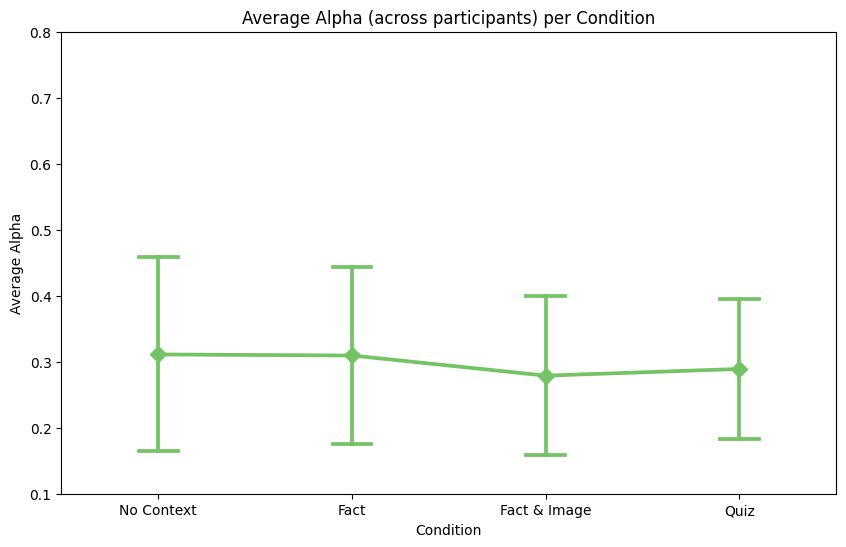

In [13]:
plot_alpha_participants_per_condition_new(alpha_lists)

In [14]:
for i in range(len(alpha_lists)):
    for j in range(i+1, len(alpha_lists)):
        uvalue, pvalue = mannwhitneyu(alpha_lists[i], alpha_lists[j])
        print(f"Comparison between group {i+1} and group {j+1}:")
        print("U-value:", uvalue)
        print("P-value:", pvalue)

Comparison between group 1 and group 2:
U-value: 3203.5
P-value: 0.7936413088425947
Comparison between group 1 and group 3:
U-value: 3682.0
P-value: 0.11967978003905795
Comparison between group 1 and group 4:
U-value: 3156.0
P-value: 0.7714101880379135
Comparison between group 2 and group 3:
U-value: 3643.0
P-value: 0.0836454924930218
Comparison between group 2 and group 4:
U-value: 3160.0
P-value: 0.5574530269922371
Comparison between group 3 and group 4:
U-value: 2615.5
P-value: 0.1925601943171278


In [15]:
# NEW

In [16]:
def plot_rt_participants_per_condition(data_dict: dict) -> None:     
    # Create a DataFrame with the average 'alpha' for each condition for each participant
    data = []
    for participant_id, participant_data in data_dict.items():
        for condition, rt in participant_data['stats']['avg_rt_per_condition'].items(): # importantly, participant_data['stats']['avg_alpha_per_condition'] is a dict as ['avg_alpha_per_condition'] is the key and the value is the list containing the avg_alpha of each condition
            data.append({
                'participant_id': participant_id,
                'condition': condition,
                'avg_rt': rt
            })
    df = pd.DataFrame(data)

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='condition', y='avg_rt', data=df, color='#74C365')
    sns.swarmplot(x='condition', y='avg_rt', data=df, color='#D35151') # a swarmplot plots the participant values themselves (here with red color)
    plt.xticks([0, 1, 2, 3], ['No Context', 'Fact', 'Fact & Image', 'Quiz'])

    plt.title('Average RT (across participants) per Condition')
    plt.xlabel('Condition')
    plt.ylabel('Average RT')

    plt.show()

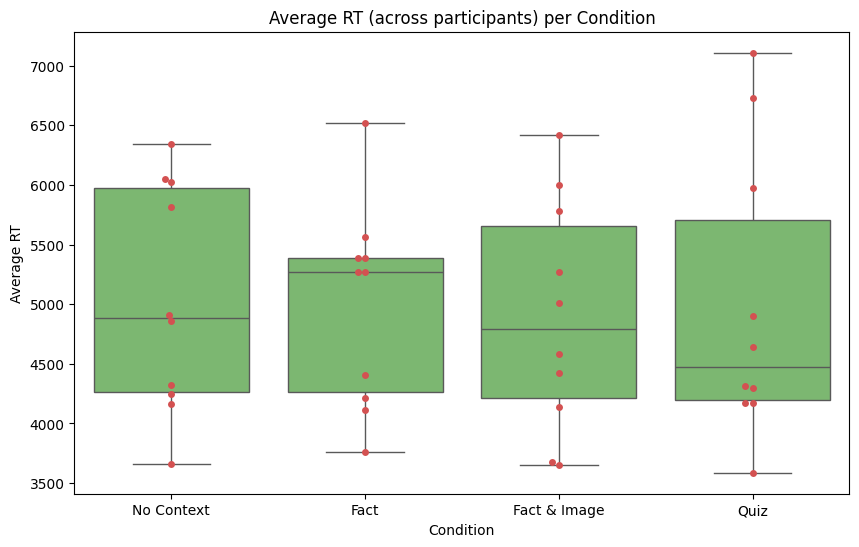

In [17]:
plot_rt_participants_per_condition(data_dict)

Choose a participant:

In [18]:
data_dict.keys()

dict_keys(['20231103095032', '20231103111225', '20231103135654', '20231103171914', '20231104153357', '20231104153436', '20231105135654', '20231105144350', '20231105190408', '20231107191557'])

In [19]:
participant_id = '20231103171914'

In [20]:
# Plot within participant RT across conditions of selected participant
def plot_within_variation_rt(participant_id: str, data_dict: dict) -> None:

    # Group the data by 'condition' and calculate the mean and standard deviation of 'rt'
    grouped = data_dict[participant_id]['df'].groupby('condition')['rt']
    means = grouped.mean()
    stds = grouped.std()

    plt.figure(figsize=(10, 6))

    # Plot the means with error bars
    plt.errorbar(x=np.arange(4), y=means, yerr=stds, fmt='o', color='#74C365', markerfacecolor='#D35151', markersize=9, capsize=5)
    
    # Set the x-axis labels
    plt.xticks([0, 1, 2, 3], ['No Context', 'Fact', 'Fact & Image', 'Quiz'])

    plt.ylabel('Average RT')
    plt.xlabel('Condition')
    plt.title('Within-participant Variation in RT')
    plt.ylim([2500, 10000])
    plt.show()

In [21]:
# Plot within participant Alpha across conditions of the selected participant
def plot_within_variation_alpha(participant_id: str, data_dict: dict) -> None:
    
    # Group the data by 'condition' and calculate the mean and standard deviation of 'alpha'
    grouped = data_dict[participant_id]['df'].groupby('condition')['alpha']
    means = grouped.mean()
    stds = grouped.std()

    plt.figure(figsize=(10, 6))

    # Plot the means with error bars
    plt.errorbar(x=np.arange(4), y=means, yerr=stds, fmt='o', color='#74C365', markerfacecolor='#D35151', markersize=9, capsize=5)

    # Set the x-axis labels
    plt.xticks([0, 1, 2, 3], ['No Context', 'Fact', 'Fact & Image', 'Quiz'])

    plt.ylabel('Mean Alpha')
    plt.xlabel('Condition')
    plt.title('Within-participant Variation in Alpha')
    plt.show()


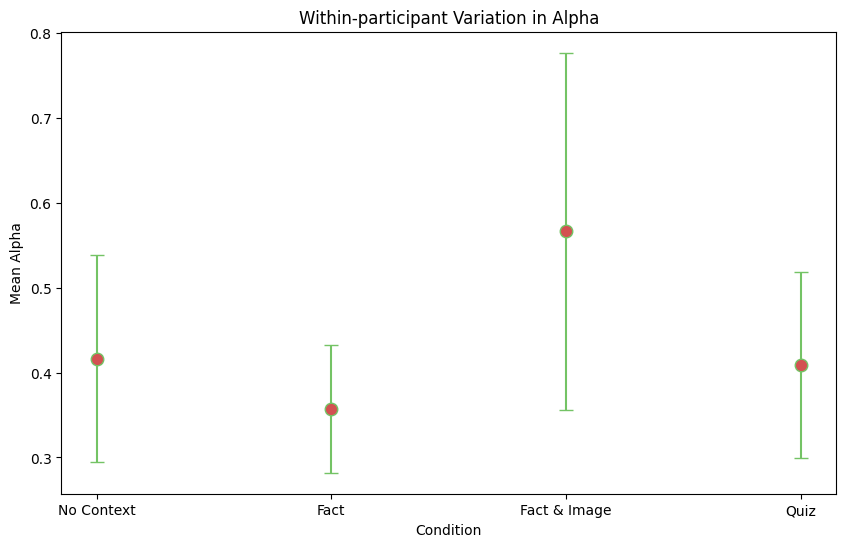

In [22]:
plot_within_variation_alpha(participant_id, data_dict)

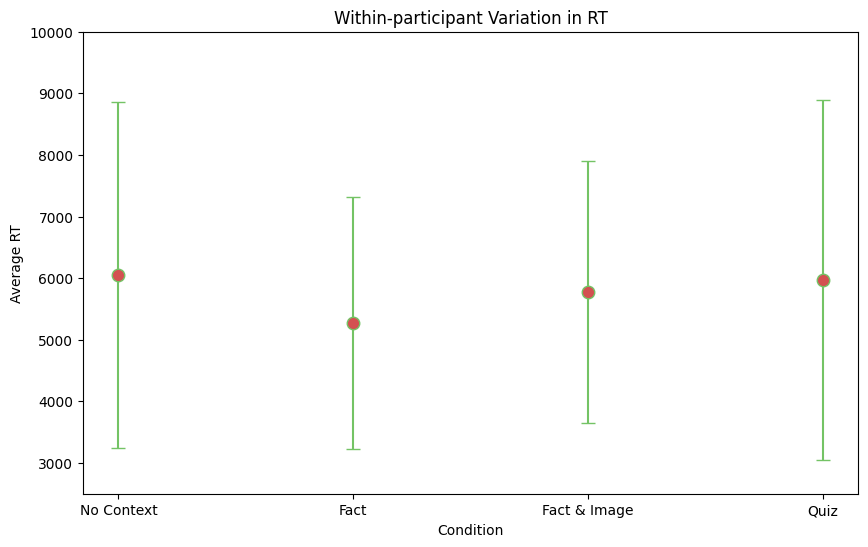

In [23]:
plot_within_variation_rt(participant_id, data_dict)

- The plots and metrics so far indicated the average differences. However, to check if these differences are statistically significant we need to do a few statistical tests.
- Below we show the results of an ANOVA test.

In [24]:
# Check ANOVA assumptions

# Concatenate all dfs
all_data = pd.concat([participant_data['df'] for participant_data in data_dict.values()])

# Group the data by 'condition' and get the 'alpha' values
grouped = all_data.groupby('condition')['alpha']

# Check normality assumption for each condition
for condition, alpha in grouped:
    print(f"Shapiro-Wilk Test for {condition}:", stats.shapiro(alpha))

Shapiro-Wilk Test for 0: ShapiroResult(statistic=0.9042068719863892, pvalue=3.991384350773824e-21)
Shapiro-Wilk Test for 1: ShapiroResult(statistic=0.8884923458099365, pvalue=9.607679590738367e-22)
Shapiro-Wilk Test for 2: ShapiroResult(statistic=0.8869243264198303, pvalue=6.897100609920335e-21)
Shapiro-Wilk Test for 3: ShapiroResult(statistic=0.8887808322906494, pvalue=8.579572243362555e-20)


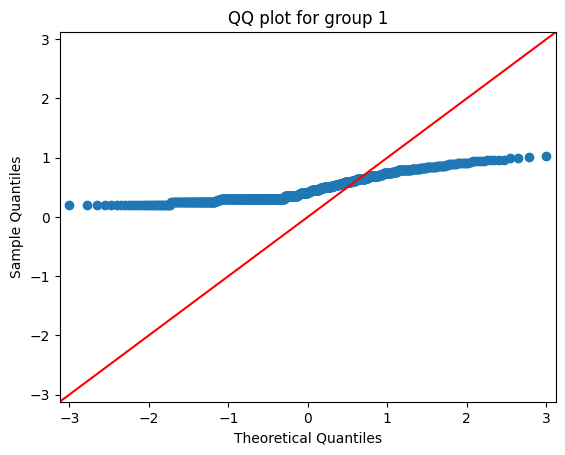

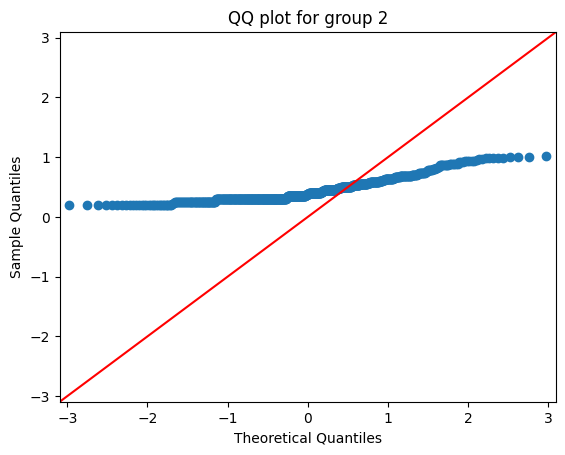

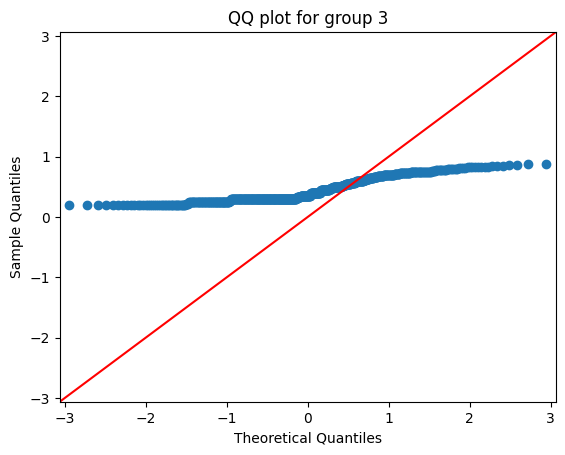

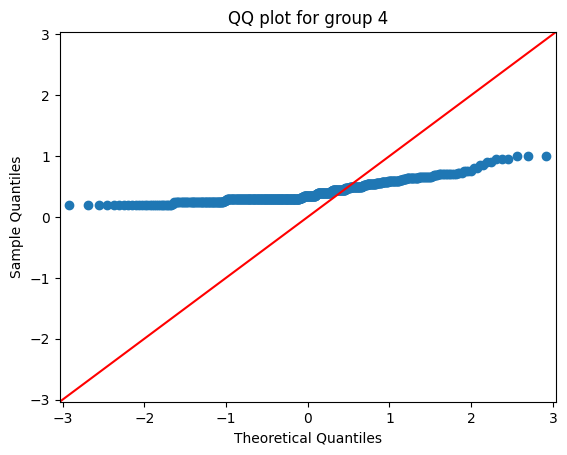

In [25]:
# Concatenate all dfs
concat_dfs = pd.concat([participant_data['df'] for participant_data in data_dict.values()])

# Group the data by 'condition' and get the 'rt' values
grouped = concat_dfs.groupby('condition')['alpha']

# Convert each group to a list and store them in a new list
groups = [alphas.tolist() for condition, alphas in grouped]

# Create a QQ plot for each group
for i, group in enumerate(groups):
    sm.qqplot(np.array(group), line ='45')
    plt.title(f'QQ plot for group {i+1}')
    plt.show()

In [26]:
# ANOVA follows

# Concatenate all dfs
concat_dfs = pd.concat([participant_data['df'] for participant_data in data_dict.values()])

# Group the data by 'condition' and get the 'rt' values
grouped = concat_dfs.groupby('condition')['alpha']

# Convert each group to a list and store them in a new list
groups = [alphas.tolist() for condition, alphas in grouped]

fvalue, pvalue = stats.f_oneway(*groups)

print("F-value:", fvalue)
print("P-value:", pvalue)

F-value: 15.23335094558821
P-value: 7.941692375616981e-10


In [27]:
for i, group in enumerate(groups):
    print(f"Length of group {i+1}: {len(group)}")

Length of group 1: 740
Length of group 2: 680
Length of group 3: 620
Length of group 4: 567


- The variable <code><a>groups</a></code> now contains the data across all participants for every one of the four conditions. 
- We now try a non-parametric test, the Mann–Whitney U test which does not require the same assumptions as ANOVA.
- We conduct the test for all pairwise comparisons between the four conditions.

In [28]:
# Concatenate all dfs
concat_dfs = pd.concat([participant_data['df'] for participant_data in data_dict.values()])

# Group the data by 'condition' and get the 'rt' values
grouped = concat_dfs.groupby('condition')['alpha']

# Convert each group to a list and store them in a new list
groups = [alphas.tolist() for condition, alphas in grouped]

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        uvalue, pvalue = mannwhitneyu(groups[i], groups[j])
        print(f"Comparison between group {i+1} and group {j+1}:")
        print("U-value:", uvalue)
        print("P-value:", pvalue)

Comparison between group 1 and group 2:
U-value: 273244.0
P-value: 0.004758054014969044
Comparison between group 1 and group 3:
U-value: 251058.0
P-value: 0.0024851764788041916
Comparison between group 1 and group 4:
U-value: 245611.5
P-value: 9.333642761548201e-08
Comparison between group 2 and group 3:
U-value: 212397.5
P-value: 0.8117413379493779
Comparison between group 2 and group 4:
U-value: 209527.5
P-value: 0.007630677568870389
Comparison between group 3 and group 4:
U-value: 189745.0
P-value: 0.016734001384811393


In [29]:
# Propportion correct per condition

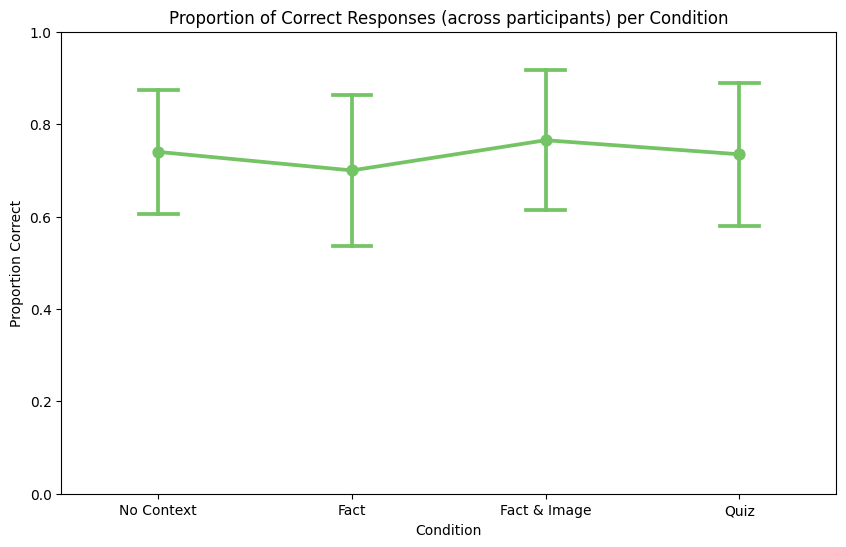

In [30]:
condition1 = []
condition2 = []
condition3 = []
condition4 = []

for participant_id in data_dict.keys():
    x = data_dict[participant_id]['stats']['proportion_correct_per_condition']
    condition1.append(x[0]) 
    condition2.append(x[1]) 
    condition3.append(x[2]) 
    condition4.append(x[3]) 

conditions = [condition1, condition2, condition3, condition4]

# Proportion of correct responses per condition across all participants
def plot_correct_participants_per_condition(conditions: list) -> None:
    # Create labels for the boxplots
    labels = ['No Context', 'Fact', 'Fact & Image', 'Quiz']

    # Create a Seaborn pointplot
    plt.figure(figsize=(10, 6))
    sns.pointplot(data=conditions, errorbar="sd", capsize=0.2, color='#74C365') 
    
    plt.title('Proportion of Correct Responses (across participants) per Condition')
    plt.xlabel('Condition')
    plt.ylabel('Proportion Correct')
    plt.ylim(0.0, 1.0)
    plt.xticks(range(4), labels)
    
    plt.show()

plot_correct_participants_per_condition(conditions)

Power Analysis

In [31]:
from statsmodels.stats.power import FTestAnovaPower

# Initialize parameters
effect_size = 0.5
alpha = 0.05
power = 0.8
k_groups = 4

# Create an instance of the power calculator
power_analysis = FTestAnovaPower()

# Calculate the number of observations
nobs = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=k_groups)

# Print the result
print(f"You need approximately {nobs:.2f} participants per group for an effect size of {effect_size}, given an alpha of {alpha}, power of {power}, and {k_groups} groups.")

You need approximately 47.70 participants per group for an effect size of 0.5, given an alpha of 0.05, power of 0.8, and 4 groups.
You need approximately 11.93 participants per group.


In [32]:
#     plt.savefig(filename)